In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

In [3]:
mnist = MNIST(
    root='data',
    train=True, 
    download=True,
    transform = Compose([ToTensor(), Normalize(mean=(0.5,), std = (0.5,))])
             )


0it [00:00, ?it/s]

 96%|█████████████████████████████████████████████  | 9502720/9912422 [00:04<00:00, 3815136.06it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



0it [00:00, ?it/s]


 57%|██████████████████████████████                       | 16384/28881 [00:01<00:00, 43563.65it/s]

0it [00:00, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




  0%|                                                                  | 0/1648877 [00:01<?, ?it/s]

 11%|█████▏                                          | 180224/1648877 [00:01<00:00, 1736560.22it/s]

 36%|█████████████████▏                              | 589824/1648877 [00:01<00:00, 2927922.06it/s]

 63%|█████████████████████████████▍                 | 1032192/1648877 [00:01<00:00, 3524745.06it/s]

 91%|██████████████████████████████████████████▋    | 1499136/1648877 [00:01<00:00, 3950078.94it/s]



0it [00:00, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw






  0%|                                                                     | 0/4542 [00:01<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...
Done!



9920512it [00:18, 3815136.06it/s]                                                                  

1654784it [00:11, 3950078.94it/s]                                                                  

In [4]:
img, label = mnist[0]
print("Label: ", label)

Label:  5


In [5]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

9920512it [00:50, 194729.34it/s] 
32768it [00:46, 711.21it/s]  
1654784it [00:44, 37113.27it/s]  
8192it [00:42, 190.95it/s]                                                                         


Label: 5


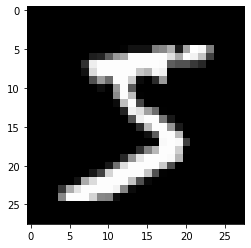

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [7]:
batch_size = 100

In [8]:
from torch.utils.data import DataLoader

In [9]:
data_loader = DataLoader(mnist, batch_size, shuffle = True)

torch.Size([100, 1, 28, 28])
tensor([9, 7, 4, 9, 5, 5, 2, 6, 5, 1, 0, 6, 5, 3, 6, 1, 1, 5, 0, 4, 6, 9, 3, 2,
        5, 4, 1, 4, 3, 2, 9, 4, 8, 1, 7, 7, 7, 7, 7, 3, 1, 0, 4, 0, 5, 1, 5, 2,
        6, 5, 3, 4, 7, 2, 7, 6, 7, 3, 4, 0, 4, 3, 2, 9, 1, 0, 9, 9, 8, 5, 0, 8,
        7, 9, 4, 5, 5, 4, 1, 5, 7, 7, 8, 1, 5, 8, 4, 6, 9, 6, 7, 2, 8, 6, 0, 4,
        9, 2, 0, 4])


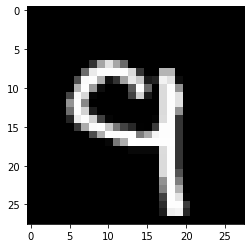

In [10]:
for img_batch, label_batch in data_loader:
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
device

device(type='cuda')

In [13]:
image_size = 28*28
hidden_size = 256

## Discriminator Model

In [14]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [15]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Generator Model

In [ ]:
latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape(-1, 28, 28)).detach()

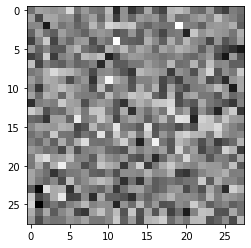

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray')

In [ ]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    d_loss = d_loss_real + d_loss_fake
    
    reset_grad()
    
    d_loss.backward()
    
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [ ]:
import os
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

In [ ]:
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow = 10)
    break

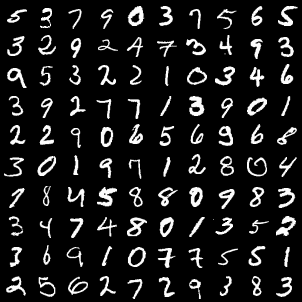

In [ ]:
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


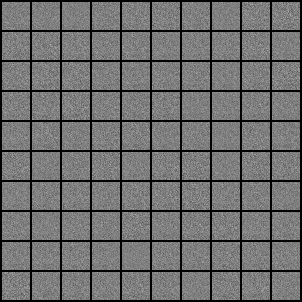

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

## Training

In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0490, g_loss: 4.2108, D(x): 1.00, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.1880, g_loss: 4.9397, D(x): 0.97, D(G(z)): 0.13
Epoch [0/300], Step [600/600], d_loss: 0.0641, g_loss: 5.7819, D(x): 0.97, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0432, g_loss: 4.8745, D(x): 1.00, D(G(z)): 0.04
Epoch [1/300], Step [400/600], d_loss: 0.0558, g_loss: 5.5845, D(x): 0.97, D(G(z)): 0.02
Epoch [1/300], Step [600/600], d_loss: 0.4288, g_loss: 4.3176, D(x): 0.90, D(G(z)): 0.22
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.1440, g_loss: 5.9180, D(x): 0.95, D(G(z)): 0.06
Epoch [2/300], Step [400/600], d_loss: 0.2319, g_loss: 5.0763, D(x): 0.95, D(G(z)): 0.12
Epoch [2/300], Step [600/600], d_loss: 0.6776, g_loss: 4.3638, D(x): 0.81, D(G(z)): 0.13
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2101, g_loss: 2.6772, D(x): 0.94, D(G(z)): 0.11
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.2959, g_loss: 3.5913, D(x): 0.94, D(G(z)): 0.13
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.5096, g_loss: 3.8988, D(x): 0.82, D(G(z)): 0.03
Epoch [28/300], Step [400/600], d_loss: 0.2562, g_loss: 3.8779, D(x): 0.89, D(G(z)): 0.06
Epoch [28/300], Step [600/600], d_loss: 0.6170, g_loss: 4.4922, D(x): 0.80, D(G(z)): 0.03
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.3208, g_loss: 4.7214, D(x): 0.91, D(G(z)): 0.07
Epoch [29/300], Step [400/600], d_loss: 0.5147, g_loss: 3.8217, D(x): 0.83, D(G(z)): 0.10
Epoch [29/300], Step [600/600], d_loss: 0.4385, g_loss: 1.7807, D(x): 0.90, D(G(z)): 0.16
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.3730, g_loss: 3.2282, D(x): 0.90, D(G(z)): 0.15
Epoch [30/300], Step [400/600], d_loss: 0.6695, g_loss: 2.6610, D(x): 0.87, D(G(z)): 0.23
Epoch [30/300], Step [600/600], d_loss: 0.3293, g_loss: 3.2979, D(x): 0.91, D(G(z)): 0.13
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.4381, g_loss: 2.4751, D(x): 0.86, D(G(z)): 0.17
Epoch [55/300], Step [600/600], d_loss: 0.5919, g_loss: 2.4495, D(x): 0.79, D(G(z)): 0.16
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.6641, g_loss: 2.3521, D(x): 0.87, D(G(z)): 0.31
Epoch [56/300], Step [400/600], d_loss: 0.6237, g_loss: 2.4249, D(x): 0.78, D(G(z)): 0.15
Epoch [56/300], Step [600/600], d_loss: 0.4454, g_loss: 2.4869, D(x): 0.84, D(G(z)): 0.14
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.7270, g_loss: 2.4160, D(x): 0.85, D(G(z)): 0.30
Epoch [57/300], Step [400/600], d_loss: 0.8235, g_loss: 2.1309, D(x): 0.85, D(G(z)): 0.32
Epoch [57/300], Step [600/600], d_loss: 0.5902, g_loss: 4.0850, D(x): 0.86, D(G(z)): 0.21
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.4593, g_loss: 2.6000, D(x): 0.81, D(G(z)): 0.11
Epoch [58/300], Step [400/600], d_loss: 0.5848, g_loss: 3.3410, D(x): 0.82, D(G(z)): 0.18
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.6156, g_loss: 2.9759, D(x): 0.74, D(G(z)): 0.15
Epoch [83/300], Step [400/600], d_loss: 0.7087, g_loss: 1.9287, D(x): 0.79, D(G(z)): 0.26
Epoch [83/300], Step [600/600], d_loss: 0.7494, g_loss: 2.0233, D(x): 0.74, D(G(z)): 0.22
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.5877, g_loss: 2.4693, D(x): 0.81, D(G(z)): 0.21
Epoch [84/300], Step [400/600], d_loss: 0.7774, g_loss: 3.2880, D(x): 0.71, D(G(z)): 0.16
Epoch [84/300], Step [600/600], d_loss: 0.9624, g_loss: 1.6682, D(x): 0.68, D(G(z)): 0.25
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.8229, g_loss: 1.9494, D(x): 0.73, D(G(z)): 0.28
Epoch [85/300], Step [400/600], d_loss: 0.7515, g_loss: 1.8965, D(x): 0.74, D(G(z)): 0.21
Epoch [85/300], Step [600/600], d_loss: 0.8948, g_loss: 2.6418, D(x): 0.74, D(G(z)): 0.25
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.6463, g_loss: 1.7946, D(x): 0.77, D(G(z)): 0.22
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.7496, g_loss: 2.1674, D(x): 0.81, D(G(z)): 0.29
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.7672, g_loss: 1.9377, D(x): 0.74, D(G(z)): 0.22
Epoch [111/300], Step [400/600], d_loss: 0.6824, g_loss: 1.4076, D(x): 0.81, D(G(z)): 0.28
Epoch [111/300], Step [600/600], d_loss: 0.9187, g_loss: 1.3184, D(x): 0.68, D(G(z)): 0.27
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.8055, g_loss: 2.0773, D(x): 0.78, D(G(z)): 0.31
Epoch [112/300], Step [400/600], d_loss: 0.9442, g_loss: 1.5830, D(x): 0.69, D(G(z)): 0.25
Epoch [112/300], Step [600/600], d_loss: 0.9278, g_loss: 1.5017, D(x): 0.71, D(G(z)): 0.26
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.8756, g_loss: 1.3712, D(x): 0.78, D(G(z)): 0.32
Epoch [113/300], Step [400/600], d_loss: 0.9596, g_loss: 1.4764, D(x): 0.69, D(G(z)): 0.31
Epoch [113/300], Step [600/600], d_loss: 0.9835, g_loss: 1.3922, D(x): 0.63, D(G(z)): 0.23
Saving

Epoch [138/300], Step [200/600], d_loss: 1.0475, g_loss: 1.1223, D(x): 0.70, D(G(z)): 0.37
Epoch [138/300], Step [400/600], d_loss: 0.9607, g_loss: 1.3667, D(x): 0.71, D(G(z)): 0.35
Epoch [138/300], Step [600/600], d_loss: 0.7759, g_loss: 1.8491, D(x): 0.72, D(G(z)): 0.24
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.9431, g_loss: 1.5953, D(x): 0.65, D(G(z)): 0.25
Epoch [139/300], Step [400/600], d_loss: 0.8935, g_loss: 1.7612, D(x): 0.64, D(G(z)): 0.20
Epoch [139/300], Step [600/600], d_loss: 0.8197, g_loss: 1.8234, D(x): 0.74, D(G(z)): 0.28
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.8306, g_loss: 1.9190, D(x): 0.72, D(G(z)): 0.27
Epoch [140/300], Step [400/600], d_loss: 0.8079, g_loss: 1.5021, D(x): 0.71, D(G(z)): 0.26
Epoch [140/300], Step [600/600], d_loss: 1.0468, g_loss: 1.2899, D(x): 0.70, D(G(z)): 0.32
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 1.0685, g_loss: 1.7612, D(x): 0.61, D(G(z)): 0.27
Epoch 

Epoch [165/300], Step [400/600], d_loss: 1.1417, g_loss: 1.5153, D(x): 0.60, D(G(z)): 0.33
Epoch [165/300], Step [600/600], d_loss: 0.9412, g_loss: 1.7657, D(x): 0.63, D(G(z)): 0.23
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.9208, g_loss: 1.3736, D(x): 0.70, D(G(z)): 0.31
Epoch [166/300], Step [400/600], d_loss: 0.8887, g_loss: 1.3961, D(x): 0.75, D(G(z)): 0.34
Epoch [166/300], Step [600/600], d_loss: 1.0062, g_loss: 2.1199, D(x): 0.65, D(G(z)): 0.25
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 1.0480, g_loss: 1.3773, D(x): 0.71, D(G(z)): 0.35
Epoch [167/300], Step [400/600], d_loss: 0.8296, g_loss: 1.4726, D(x): 0.66, D(G(z)): 0.24
Epoch [167/300], Step [600/600], d_loss: 0.8557, g_loss: 1.7384, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.9184, g_loss: 1.7034, D(x): 0.64, D(G(z)): 0.23
Epoch [168/300], Step [400/600], d_loss: 0.8264, g_loss: 1.4650, D(x): 0.72, D(G(z)): 0.30
Epoch 

Epoch [192/300], Step [600/600], d_loss: 1.0728, g_loss: 1.5801, D(x): 0.66, D(G(z)): 0.36
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.8893, g_loss: 1.4464, D(x): 0.67, D(G(z)): 0.27
Epoch [193/300], Step [400/600], d_loss: 0.9101, g_loss: 1.1433, D(x): 0.71, D(G(z)): 0.32
Epoch [193/300], Step [600/600], d_loss: 1.2301, g_loss: 1.2799, D(x): 0.71, D(G(z)): 0.46
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.8641, g_loss: 1.2384, D(x): 0.75, D(G(z)): 0.32
Epoch [194/300], Step [400/600], d_loss: 1.0313, g_loss: 1.6319, D(x): 0.77, D(G(z)): 0.41
Epoch [194/300], Step [600/600], d_loss: 0.9106, g_loss: 1.2421, D(x): 0.76, D(G(z)): 0.37
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 1.1689, g_loss: 1.7656, D(x): 0.58, D(G(z)): 0.29
Epoch [195/300], Step [400/600], d_loss: 1.1603, g_loss: 1.3378, D(x): 0.63, D(G(z)): 0.34
Epoch [195/300], Step [600/600], d_loss: 0.8988, g_loss: 1.7228, D(x): 0.75, D(G(z)): 0.31
Saving

Epoch [220/300], Step [200/600], d_loss: 0.9872, g_loss: 1.6614, D(x): 0.70, D(G(z)): 0.37
Epoch [220/300], Step [400/600], d_loss: 0.9810, g_loss: 1.7775, D(x): 0.69, D(G(z)): 0.31
Epoch [220/300], Step [600/600], d_loss: 1.0852, g_loss: 1.1633, D(x): 0.70, D(G(z)): 0.41
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.8320, g_loss: 1.3271, D(x): 0.72, D(G(z)): 0.29
Epoch [221/300], Step [400/600], d_loss: 0.9397, g_loss: 1.4344, D(x): 0.66, D(G(z)): 0.28
Epoch [221/300], Step [600/600], d_loss: 0.8713, g_loss: 1.6029, D(x): 0.76, D(G(z)): 0.32
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 1.0808, g_loss: 1.4055, D(x): 0.70, D(G(z)): 0.38
Epoch [222/300], Step [400/600], d_loss: 0.9266, g_loss: 1.3120, D(x): 0.70, D(G(z)): 0.33
Epoch [222/300], Step [600/600], d_loss: 0.9411, g_loss: 1.2412, D(x): 0.69, D(G(z)): 0.33
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 1.1263, g_loss: 1.3628, D(x): 0.55, D(G(z)): 0.24
Epoch 

Epoch [247/300], Step [400/600], d_loss: 0.8764, g_loss: 1.6597, D(x): 0.75, D(G(z)): 0.35
Epoch [247/300], Step [600/600], d_loss: 0.8390, g_loss: 1.3866, D(x): 0.71, D(G(z)): 0.27
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.9767, g_loss: 1.4043, D(x): 0.74, D(G(z)): 0.38
Epoch [248/300], Step [400/600], d_loss: 0.9696, g_loss: 1.4662, D(x): 0.69, D(G(z)): 0.35
Epoch [248/300], Step [600/600], d_loss: 1.0588, g_loss: 1.4584, D(x): 0.68, D(G(z)): 0.35
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.9502, g_loss: 1.4536, D(x): 0.69, D(G(z)): 0.31
Epoch [249/300], Step [400/600], d_loss: 0.9183, g_loss: 1.6334, D(x): 0.68, D(G(z)): 0.27
Epoch [249/300], Step [600/600], d_loss: 0.7787, g_loss: 1.9521, D(x): 0.75, D(G(z)): 0.29
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.8479, g_loss: 1.5736, D(x): 0.70, D(G(z)): 0.26
Epoch [250/300], Step [400/600], d_loss: 0.9540, g_loss: 1.3157, D(x): 0.72, D(G(z)): 0.35
Epoch 

Epoch [274/300], Step [600/600], d_loss: 0.8981, g_loss: 1.2501, D(x): 0.73, D(G(z)): 0.32
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.9179, g_loss: 1.5966, D(x): 0.68, D(G(z)): 0.29
Epoch [275/300], Step [400/600], d_loss: 0.9027, g_loss: 1.7433, D(x): 0.72, D(G(z)): 0.32
Epoch [275/300], Step [600/600], d_loss: 0.9831, g_loss: 1.1154, D(x): 0.72, D(G(z)): 0.35
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 1.0091, g_loss: 1.3583, D(x): 0.61, D(G(z)): 0.26
Epoch [276/300], Step [400/600], d_loss: 0.7986, g_loss: 1.0594, D(x): 0.78, D(G(z)): 0.34
Epoch [276/300], Step [600/600], d_loss: 1.1552, g_loss: 1.5890, D(x): 0.55, D(G(z)): 0.23
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 1.0375, g_loss: 1.5767, D(x): 0.70, D(G(z)): 0.33
Epoch [277/300], Step [400/600], d_loss: 0.9997, g_loss: 1.6290, D(x): 0.63, D(G(z)): 0.28
Epoch [277/300], Step [600/600], d_loss: 0.9601, g_loss: 1.3172, D(x): 0.73, D(G(z)): 0.37
Saving

## Saving Generator and Discriminator model weights

In [ ]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

## Visualizing Training

In [ ]:
import cv2
from IPython.display import FileLink

In [ ]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 5, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

E:\Projects\PyTorch_Projects\MNIST_GANs_PyTorch\gans_training.avi

## Accuracy and Losses Graph

Text(0.5, 1.0, 'Losses')

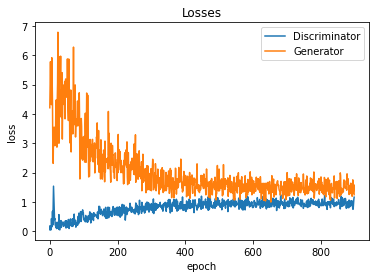

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

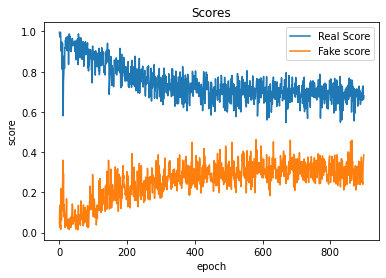

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');